<a href="https://colab.research.google.com/github/mehdihasan010/Learn_ML/blob/master/MangoLeafDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = '/content/drive/MyDrive/Mango_Leaf_Dataset'
ds_name = 'Mango Leaf Disease'

In [9]:
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [10]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [11]:
df

,filepaths,labels
0,/content/drive/MyDrive/Mango_Leaf_Dataset/Heal...,Healthy
1,/content/drive/MyDrive/Mango_Leaf_Dataset/Heal...,Healthy
2,/content/drive/MyDrive/Mango_Leaf_Dataset/Heal...,Healthy
3,/content/drive/MyDrive/Mango_Leaf_Dataset/Heal...,Healthy
4,/content/drive/MyDrive/Mango_Leaf_Dataset/Heal...,Healthy
...,...,...
3995,/content/drive/MyDrive/Mango_Leaf_Dataset/Cutt...,Cutting Weevil
3996,/content/drive/MyDrive/Mango_Leaf_Dataset/Cutt...,Cutting Weevil
3997,/content/drive/MyDrive/Mango_Leaf_Dataset/Cutt...,Cutting Weevil
3998,/content/drive/MyDrive/Mango_Leaf_Dataset/Cutt...,Cutting Weevil


In [12]:
def num_of_examples(df, name='df'):
    print(f"{name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

Mango Leaf Disease dataset has 4000 images.


In [13]:
def num_of_classes(df, name='df'):
    print(f"{name} dataset has {len(df['labels'].unique())} classes.")

num_of_classes(df, ds_name)

Mango Leaf Disease dataset has 8 classes.


In [14]:
def classes_count(df, name='df'):

    print(f"{name} dataset: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}'class has  {num_class} images. ")
        print('-'*70)

classes_count(df, ds_name)

Mango Leaf Disease dataset: 

'Healthy'class has  500 images. 
----------------------------------------------------------------------
'Die Back'class has  500 images. 
----------------------------------------------------------------------
'Powdery Mildew'class has  500 images. 
----------------------------------------------------------------------
'Gall Midge'class has  500 images. 
----------------------------------------------------------------------
'Bacterial Canker'class has  500 images. 
----------------------------------------------------------------------
'Sooty Mould'class has  500 images. 
----------------------------------------------------------------------
'Anthracnose'class has  500 images. 
----------------------------------------------------------------------
'Cutting Weevil'class has  500 images. 
----------------------------------------------------------------------


**Process of Visualizing Each Class in the Dataset**

In [15]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage Chart'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

cat_summary_with_graph(df,'labels')

In [16]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"{name} DataFrame has no null values.")

    else:
        print(f"The {name} DataFrame has {num_null_vals} null values.")
        print('-'*70)
        print('Total null values in each column:')
        print(df.isnull().sum())


check_null_values(df, ds_name)

Mango Leaf Disease DataFrame has no null values.


In [17]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [18]:
def num_imgs(df, name='df'):
    print(f"{name} set contains {len(df)} images.")

In [19]:
num_imgs(train_df, 'Training ')
num_imgs(valid_df, 'Validation ')
num_imgs(test_df, 'Testing ')

Training  set contains 2800 images.
Validation  set contains 600 images.
Testing  set contains 600 images.


In [20]:
num_of_classes(train_df, "Training ")
num_of_classes(valid_df, "Validation ")
num_of_classes(test_df, "Testing ")

Training  dataset has 8 classes.
Validation  dataset has 8 classes.
Testing  dataset has 8 classes.


In [21]:
classes_count(train_df, 'Training '+ds_name)

Training Mango Leaf Disease dataset: 

'Gall Midge'class has  354 images. 
----------------------------------------------------------------------
'Anthracnose'class has  353 images. 
----------------------------------------------------------------------
'Powdery Mildew'class has  348 images. 
----------------------------------------------------------------------
'Healthy'class has  365 images. 
----------------------------------------------------------------------
'Bacterial Canker'class has  365 images. 
----------------------------------------------------------------------
'Cutting Weevil'class has  343 images. 
----------------------------------------------------------------------
'Die Back'class has  322 images. 
----------------------------------------------------------------------
'Sooty Mould'class has  350 images. 
----------------------------------------------------------------------


In [22]:
classes_count(valid_df, 'Validation '+ds_name)

Validation Mango Leaf Disease dataset: 

'Die Back'class has  95 images. 
----------------------------------------------------------------------
'Healthy'class has  70 images. 
----------------------------------------------------------------------
'Sooty Mould'class has  75 images. 
----------------------------------------------------------------------
'Gall Midge'class has  67 images. 
----------------------------------------------------------------------
'Powdery Mildew'class has  78 images. 
----------------------------------------------------------------------
'Cutting Weevil'class has  84 images. 
----------------------------------------------------------------------
'Anthracnose'class has  70 images. 
----------------------------------------------------------------------
'Bacterial Canker'class has  61 images. 
----------------------------------------------------------------------


In [23]:
classes_count(test_df, 'Testing '+ds_name)

Testing Mango Leaf Disease dataset: 

'Healthy'class has  65 images. 
----------------------------------------------------------------------
'Cutting Weevil'class has  73 images. 
----------------------------------------------------------------------
'Powdery Mildew'class has  74 images. 
----------------------------------------------------------------------
'Die Back'class has  83 images. 
----------------------------------------------------------------------
'Gall Midge'class has  79 images. 
----------------------------------------------------------------------
'Sooty Mould'class has  75 images. 
----------------------------------------------------------------------
'Anthracnose'class has  77 images. 
----------------------------------------------------------------------
'Bacterial Canker'class has  74 images. 
----------------------------------------------------------------------


In [24]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'filepaths',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


**Visualize training dataset**

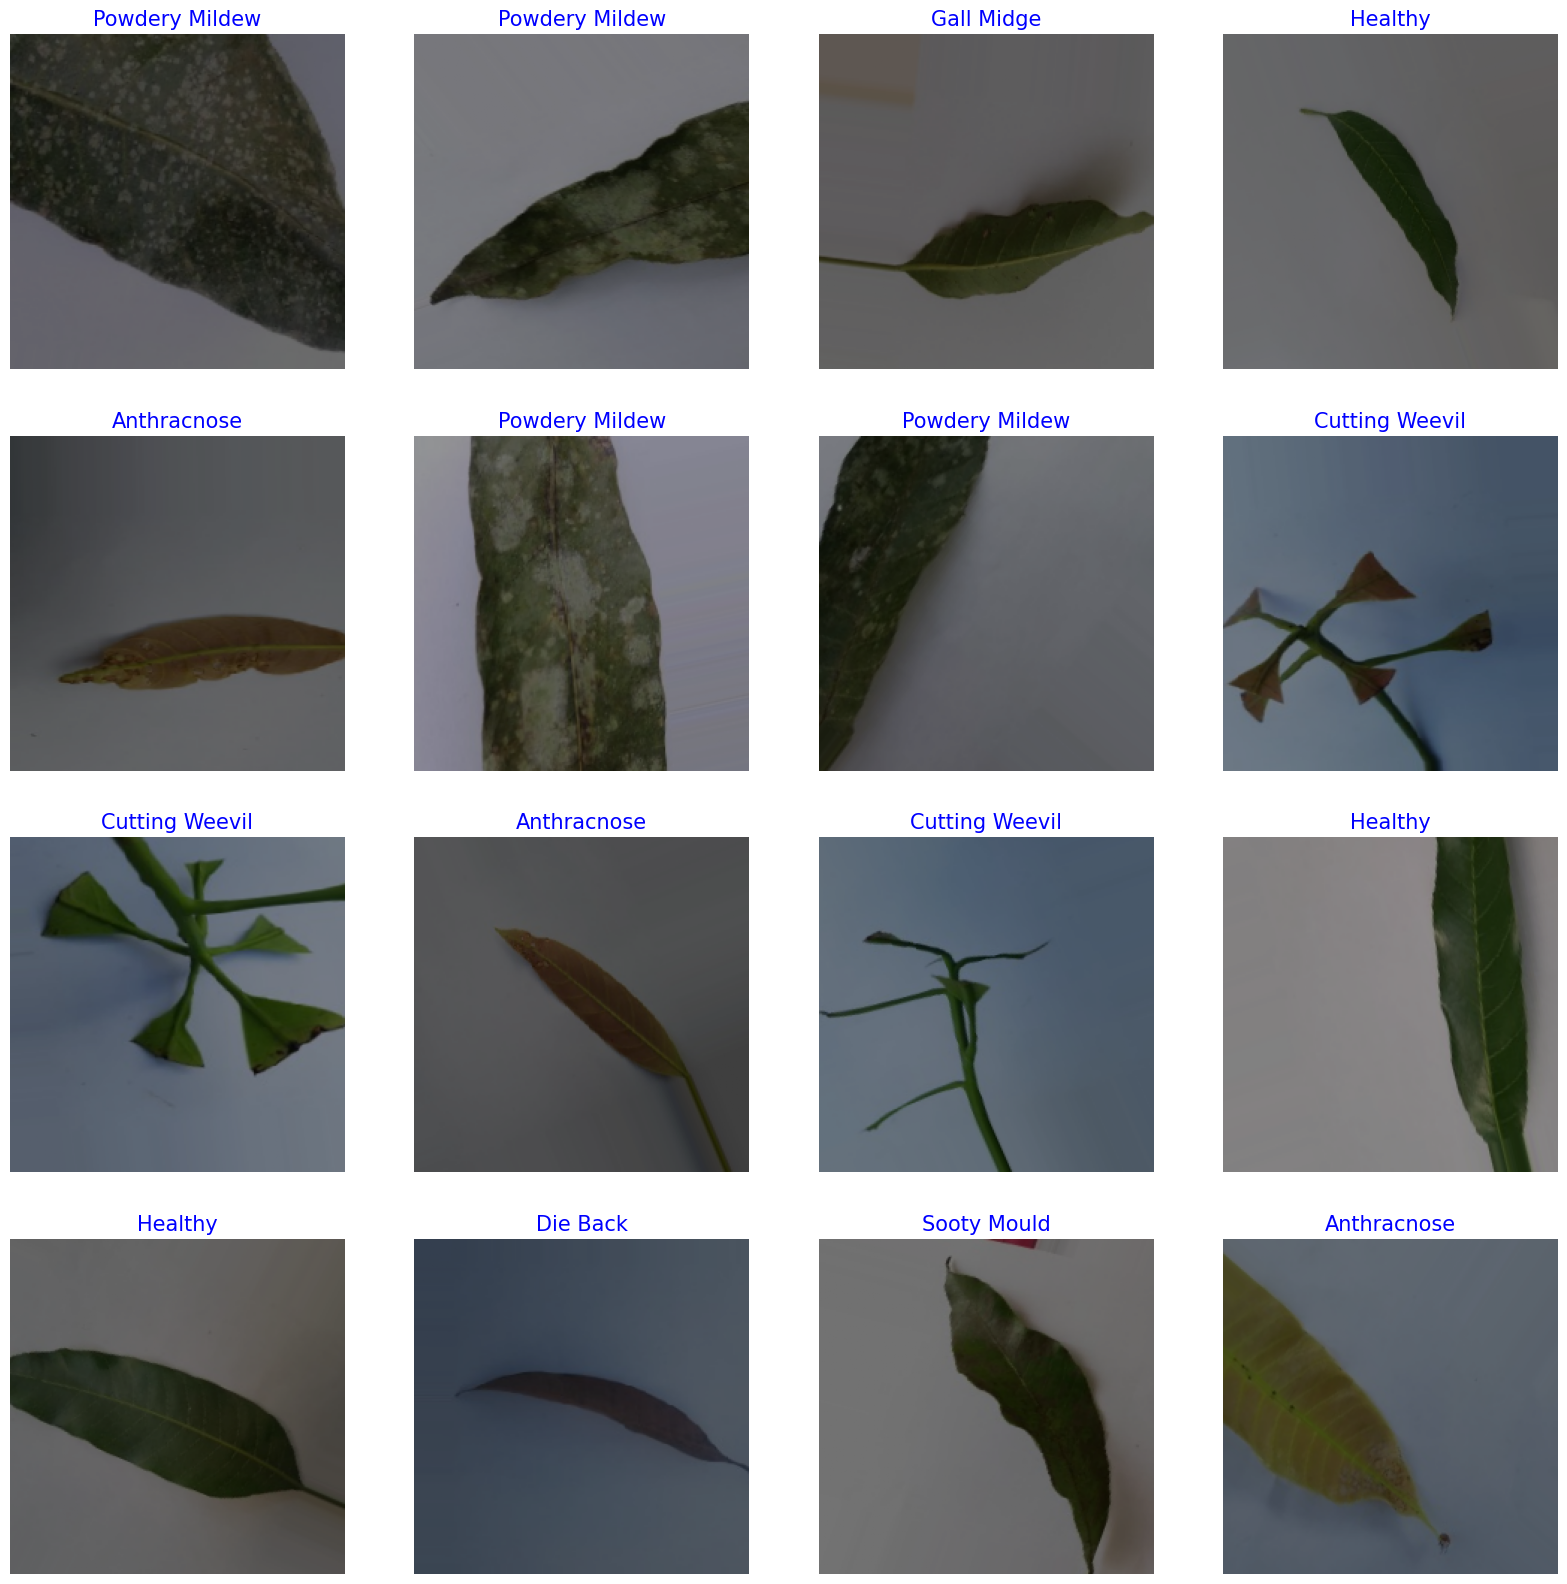

In [25]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='blue', fontsize=15)

    plt.axis('off')

plt.show()